In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arjuntejaswi/plant-village")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plant-village


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [13]:
data_dir = f"{path}/PlantVillage"

train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_val_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_val_datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [14]:
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(128, 128, 3))

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- Define Callbacks ---

checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: Reduces learning rate when validation loss stops improving
reduce_lr_on_plateau_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    mode='min',
    min_lr=0.000001,
    verbose=1
)

# Combine all callbacks into a list
my_callbacks = [
    model_checkpoint_callback,
    early_stopping_callback,
    reduce_lr_on_plateau_callback
]

# --- Train the Model with Callbacks ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=my_callbacks
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.2715 - loss: 2.3786
Epoch 1: val_accuracy improved from -inf to 0.67637, saving model to best_model.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 152s 281ms/step - accuracy: 0.2717 - loss: 2.3777 - val_accuracy: 0.6764 - val_loss: 1.1314 - learning_rate: 1.0000e-04
Epoch 2/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.5939 - loss: 1.3056
Epoch 2: val_accuracy improved from 0.67637 to 0.74163, saving model to best_model.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 159s 203ms/step - accuracy: 0.5939 - loss: 1.3055 - val_accuracy: 0.7416 - val_loss: 0.8610 - learning_rate: 1.0000e-04
Epoch 3/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6626 - loss: 1.0662
Epoch 3: val_accuracy improved from 0.74163 to 0.77681, saving model to best_model.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 103s 200ms/step - accuracy: 0.6626 - loss: 1.0661 - val_accuracy: 0.7768 - val_loss: 0.7343 - learning_rate: 1.0000e-04
Epoch 4/50
517/517 ━━━━━━

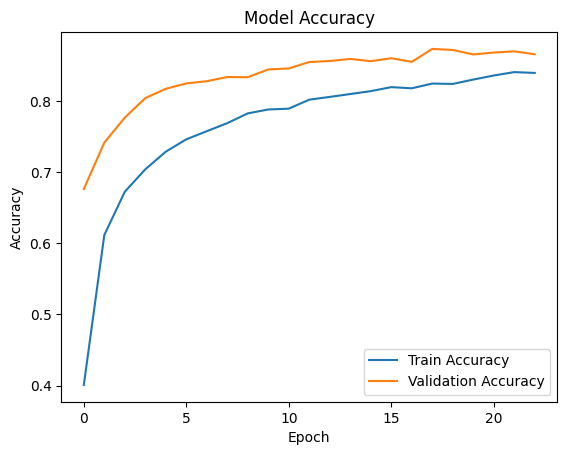

In [15]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()